<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/imdb_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Sentiment Prediction with Embeddings layer



## Import

In [60]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM,\
                         TextVectorization, MaxPooling1D, Dropout

## Dataset

In [61]:
# Dataset - 2880 movie reviews from IMDB (raw string)
# 1440 positives, 1440 negatives

imdb_dir = '/content/drive/MyDrive/imdb-dataset/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

print("Example from dataset : ", texts[0])
print("Sentiment : ", "Negative" if labels[0] == 0 else "Positive")

Example from dataset :  Perhaps I'm being too generous when I give this film two and a half stars out of five, but there was an occasional moment. However, as "An American Werewolf" movie this one is a missed chance! There are no real plot connections to the superior original to speak of, but the story is similar in some ways to "London".<br /><br />*Possible Spoiler Warning* American kids go to foreign country, one falls in love with a beautiful girl. Another one of the kids gets slaughtered by a werewolf in the same night that one gets bitten, and despite his undead friend's warnings, by the light of the full moon he sprouts fur, fangs, and claws!<br /><br />But there are some differences in the story, for one; the girl is one of the werewolves. Second; there are three American Kids. And third; there's some weird-@$$ werewolf cult intent on taking over the world! As crazy as it sounds, that last one, WASN'T a joke! *Spoiler Ends*<br /><br />The films suffers from many things, first t

In [62]:
## Normalize text

import re

def regularize(text):
  text =  re.sub('[^a-zA-Z0-9 \n\.]', '', text) # remove special chars
  
  return text

texts = [regularize(text) for text in texts]

In [63]:
# Preprocessing - sentences to sequences

maxlen = 200
max_words = 10000
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 32215 unique tokens.
Shape of data tensor: (2880, 200)
Shape of label tensor: (2880,)


In [64]:
# Splitting for test set

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

x_set = data[indices]
y_set = labels[indices]

test_sep = int(len(x_set) * 0.2)

x_train = x_set[test_sep:]
y_train = y_set[test_sep:]

x_test = x_set[:test_sep]
y_test = y_set[:test_sep]

print("Found {} elements for train set".format(len(x_train)))
print("Found {} elements for test set".format(len(x_test)))

Found 2304 elements for train set
Found 576 elements for test set


## Model

In [65]:
# Model defintion - This model should predict the sentiment of a review

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(MaxPooling1D(pool_size=5, strides=2))
model.add(Dropout(0.7))
model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 98, 100)          0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 98, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                17024     
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                      

## Training

In [66]:
# Training

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=32,
                    validation_split=0.2)

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/15
58/58 [==============================] - 8s 93ms/step - loss: 0.7789 - acc: 0.5247 - val_loss: 0.7543 - val_acc: 0.6377
Epoch 2/15
58/58 [==============================] - 7s 117ms/step - loss: 0.7165 - acc: 0.6310 - val_loss: 0.6876 - val_acc: 0.5727
Epoch 3/15
58/58 [==============================] - 5s 85ms/step - loss: 0.5583 - acc: 0.7509 - val_loss: 0.5157 - val_acc: 0.8113
Epoch 4/15
58/58 [==============================] - 6s 102ms/step - loss: 0.4141 - acc: 0.8426 - val_loss: 0.4046 - val_acc: 0.8416
Epoch 5/15
58/58 [==============================] - 8s 133ms/step - loss: 0.2927 - acc: 0.9002 - val_loss: 0.5000 - val_acc: 0.7831
Epoch 6/15
58/58 [==============================] - 6s 99ms/step - loss: 0.2058 - acc: 0.9403 - val_loss: 0.3717 - val_acc: 0.8590
Epoch 7/15
58/58 [==============================] - 6s 105ms/step - loss: 0.1831 - acc: 0.9468 - val_loss: 0.3796 - val_acc: 0.8547
Epoch 8/15
58/58 [==============================] - 5s 85ms/step - loss: 0.1310

## Results

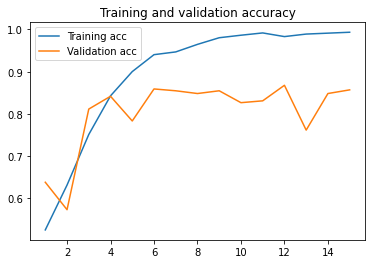

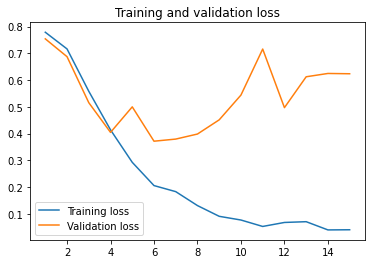

In [69]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [70]:
# Evaluate

loss, acc  = model.evaluate(x_test, y_test)
print("Accuracy : {}%".format(acc*100))

18/18 [==============================] - 0s 16ms/step - loss: 0.5309 - acc: 0.8698
Accuracy : 86.97916865348816%
